In [ ]:
import numpy as np
import torch.optim as optim
import torch.utils.data as data
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
import access_br_dwgd as access_br_dwgd
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import sys, os
sys.path.append(os.path.abspath(".."))

from utils.lstmModel import LstmModel
import utils.lstm as lstm
from utils.logger import Logger
logger = Logger.configurar_logger(nome_arquivo="lstmBrDwgd.log", nome_classe="Lstm BrDwgd")
logger.info("Iniciando script de previsão com LSTM BrDwgd.")

2025-10-05 15:36:56.378720: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-05 15:36:57,636 - Lstm BrDwgd - INFO - Iniciando script de previsão com LSTM BrDwgd.


2025-10-05 15:37:03,193 - Lstm BrDwgd - INFO - Dados carregados com sucesso. Total de 5924 registros.


[-22.98833275 -43.19055557  25.59000015]


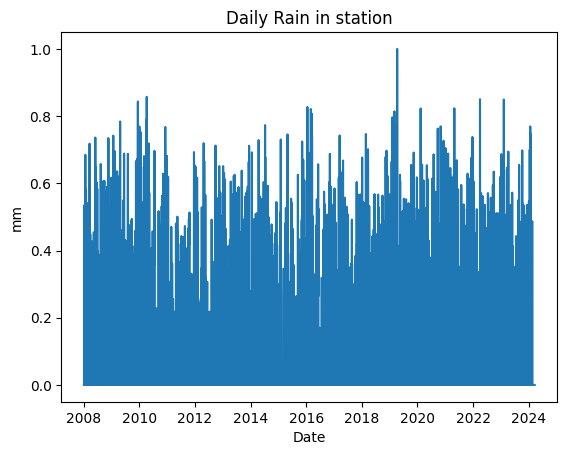

In [2]:
#Precipitation (pr, mm);
timeseries = access_br_dwgd.recuperar_dados_br_dwgd_com_area()
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(timeseries.values.reshape(-1, 1))
timeseries = pd.Series(df_scaled.flatten(), index=timeseries.index)
logger.info(f"Dados carregados com sucesso. Total de {len(timeseries)} registros.")
datas = timeseries.index 
plt.plot(timeseries)
plt.title('Daily Rain in station')
plt.xlabel('Date')
plt.ylabel('mm')
plt.show()


In [3]:
lookback = 60
logger.info(f"Preparando sequências com um lookback de {lookback} dias.")
X, y = lstm.create_sequences_pytorch(timeseries, lookback=lookback)
train_size = int(len(timeseries) * 0.77)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


dates_aligned = datas[lookback:]
train_date, test_date = dates_aligned[:train_size] , dates_aligned[train_size:]
logger.info(f"Sequências criadas. Treino: {len(X_train)} amostras, Teste: {len(X_test)} amostras.")


2025-10-05 15:37:03,312 - Lstm BrDwgd - INFO - Preparando sequências com um lookback de 60 dias.
/home/pbose/tcc/pesquisa/utils/lstm.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  target = input_data[i+lookback]
2025-10-05 15:37:03,628 - Lstm BrDwgd - INFO - Sequências criadas. Treino: 4561 amostras, Teste: 1303 amostras.


In [4]:
n_epochs = 100
batch_size = 32
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(lookback, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))  
model.compile(optimizer='adam', loss='mean_squared_error')
hist = model.fit(X_train, y_train,
                validation_data=(X_test, y_test),
                epochs=n_epochs,
                 batch_size = batch_size,
                 verbose=2)

Epoch 1/100


2025-10-05 15:37:03.644561: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/pbose/tcc/pesquisa/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


143/143 - 12s - 87ms/step - loss: 0.0322 - val_loss: 0.0343
Epoch 2/100
143/143 - 10s - 72ms/step - loss: 0.0320 - val_loss: 0.0345
Epoch 3/100
143/143 - 13s - 90ms/step - loss: 0.0319 - val_loss: 0.0343
Epoch 4/100
143/143 - 10s - 69ms/step - loss: 0.0318 - val_loss: 0.0344
Epoch 5/100
143/143 - 10s - 70ms/step - loss: 0.0318 - val_loss: 0.0345
Epoch 6/100
143/143 - 10s - 70ms/step - loss: 0.0318 - val_loss: 0.0344
Epoch 7/100
143/143 - 13s - 90ms/step - loss: 0.0317 - val_loss: 0.0342
Epoch 8/100
143/143 - 10s - 69ms/step - loss: 0.0313 - val_loss: 0.0332
Epoch 9/100
143/143 - 10s - 71ms/step - loss: 0.0294 - val_loss: 0.0314
Epoch 10/100
143/143 - 13s - 90ms/step - loss: 0.0285 - val_loss: 0.0311
Epoch 11/100
143/143 - 10s - 70ms/step - loss: 0.0286 - val_loss: 0.0311
Epoch 12/100
143/143 - 10s - 70ms/step - loss: 0.0282 - val_loss: 0.0313
Epoch 13/100
143/143 - 13s - 90ms/step - loss: 0.0283 - val_loss: 0.0312
Epoch 14/100
143/143 - 10s - 71ms/step - loss: 0.0282 - val_loss: 0.0312

In [5]:
logger.info(f"Iniciando treinamento do modelo por {n_epochs} épocas com batch_size de {batch_size}.")
best_loss = float("inf")
best_state = None
# --- Loop de Treinamento ---
# Este loop agora foca APENAS em treinar o modelo
logger.info("Realizando previsões no conjunto de teste.")
pred = model.predict(X_test)
#pred_rescaled = scaler.inverse_transform(pred)
#real_rescaled = scaler.inverse_transform(y_test)
rmse = np.sqrt(mean_squared_error(y_test, pred))
mse = mean_squared_error(y_test, pred)
mae = mean_absolute_error(y_test, pred)
logger.info(f"Avaliação do Modelo - RMSE: {rmse:.4f}, MSE: {mse:.4f}, MAE: {mae:.4f}")

y_pred_np, y_test_np = None, None

2025-10-05 15:55:19,585 - Lstm BrDwgd - INFO - Iniciando treinamento do modelo por 100 épocas com batch_size de 32.
2025-10-05 15:55:19,586 - Lstm BrDwgd - INFO - Realizando previsões no conjunto de teste.


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


2025-10-05 15:55:20,715 - Lstm BrDwgd - INFO - Avaliação do Modelo - RMSE: 0.1826, MSE: 0.0333, MAE: 0.1303


2025-10-05 15:55:20,720 - Lstm BrDwgd - INFO - Gerando gráfico de previsão final.


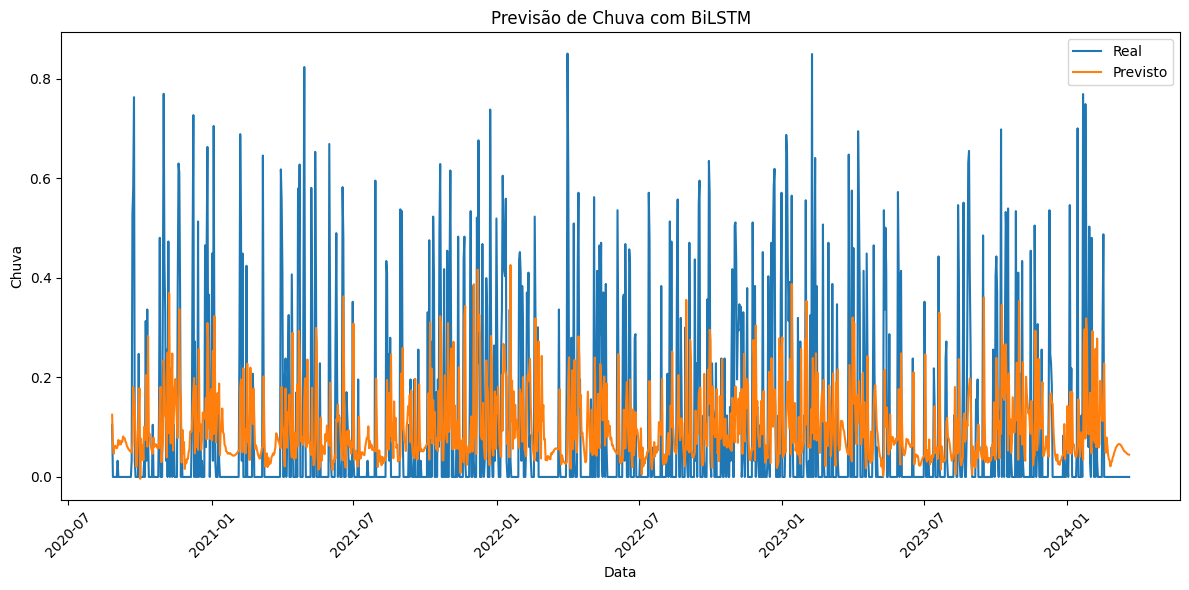

2025-10-05 15:55:20,878 - Lstm BrDwgd - INFO - Script BiLSTM BrDwgd(TensorFlow/Keras) finalizado.


In [6]:
logger.info("Gerando gráfico de previsão final.")
plt.figure(figsize=(12,6))
plt.plot(test_date, y_test, label="Real")
plt.plot(test_date, pred, label="Previsto")
plt.legend()
plt.title("Previsão de Chuva com BiLSTM")
plt.xlabel("Data")
plt.ylabel("Chuva")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
logger.info("Script BiLSTM BrDwgd(TensorFlow/Keras) finalizado.")